In [1]:
import matplotlib
# matplotlib.use('Agg')  # Or any other X11 back-end   
import numpy as np
import torch.nn as nn
import torch.nn.init as init

  
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import signal
import time
import torch
import torch.nn as nn
from torch.autograd import Variable

import h5py
import numpy as np
import os
import pandas as pd
from torch.utils.data import Dataset
import wfdb

%matplotlib inline

In [2]:
class SleepDataset(Dataset):
    """Physionet 2018 dataset."""

    def __init__(self, records_file, root_dir, s, f):
        """
        Args:
            records_file (string): Path to the records file.
            root_dir (string): Directory with all the signals.

        """
        self.landmarks_frame = pd.read_csv(records_file)[s:f]
        self.root_dir = root_dir

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        folder_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        file_name = self.landmarks_frame.iloc[idx, 0]
#         print(file_name)
#         print(folder_name)
#         file_name='tr03-0005/'
#         folder_name='../data/training/tr03-0005/'
        signals = wfdb.rdrecord(os.path.join(folder_name, file_name[:-1]))
        arousals = h5py.File(os.path.join(folder_name, file_name[:-1] + '-arousal.mat'), 'r')
        tst_ann = wfdb.rdann(os.path.join(folder_name, file_name[:-1]), 'arousal')
        
        POI = []
        for typ in ['arousal_rera', 'resp_hypopnea', 'resp_centralapnea']:
            start_idx = np.where(np.array(tst_ann.aux_note) == '('+typ)
            end_idx = np.where(np.array(tst_ann.aux_note) == typ+')')

            _starts = tst_ann.sample[start_idx]
            _ends = tst_ann.sample[end_idx]

            _width = np.subtract(_ends, _starts)
            _centers = _starts + _width//2
            POI = np.append(POI, _centers)
        
        W = tst_ann.sample[np.where(np.array(tst_ann.aux_note) == 'W')]
        N1 = tst_ann.sample[np.where(np.array(tst_ann.aux_note) == 'N1')]
        N2 = tst_ann.sample[np.where(np.array(tst_ann.aux_note) == 'N2')]
        N3 = tst_ann.sample[np.where(np.array(tst_ann.aux_note) == 'N3')]
        
       
        POI = np.append(POI, W)
        POI = np.append(POI, N1)
        POI = np.append(POI, N2)
        POI = np.append(POI, N3)
        np.random.shuffle(POI)
        interested = []
        for i in range(13):
            if signals.sig_name[i] in ['SaO2', 'ABD', 'F4-M1', 'C4-M1', 'O2-M1', 'AIRFLOW']:
                interested.append(i)
#         POI = arousal_centers
        sample =  ((signals.p_signal[:,interested], POI), np.abs(arousals['data']['arousals'].value.ravel()))
        return sample

class SleepDatasetTest(Dataset):
    """Physionet 2018 dataset."""

    def __init__(self, records_file, root_dir, s, f):
        """
        Args:
            records_file (string): Path to the records file.
            root_dir (string): Directory with all the signals.

        """
        self.landmarks_frame = pd.read_csv(records_file)[s:f]
        self.root_dir = root_dir

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        folder_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        file_name = self.landmarks_frame.iloc[idx, 0]
#         print(file_name)
#         print(folder_name)
#         file_name='tr03-0005/'
#         folder_name='../data/training/tr03-0005/'
        signals = wfdb.rdrecord(os.path.join(folder_name, file_name[:-1]))
        arousals = h5py.File(os.path.join(folder_name, file_name[:-1] + '-arousal.mat'), 'r')
        tst_ann = wfdb.rdann(os.path.join(folder_name, file_name[:-1]), 'arousal')
        
        POI = []
        for typ in ['arousal_rera', 'resp_hypopnea', 'resp_centralapnea']:
            start_idx = np.where(np.array(tst_ann.aux_note) == '('+typ)
            end_idx = np.where(np.array(tst_ann.aux_note) == typ+')')

            _starts = tst_ann.sample[start_idx]
            _ends = tst_ann.sample[end_idx]

            _width = np.subtract(_ends, _starts)
            _centers = _starts + _width//2
            POI = np.append(POI, _centers)
        
        W = tst_ann.sample[np.where(np.array(tst_ann.aux_note) == 'W')]
        N1 = tst_ann.sample[np.where(np.array(tst_ann.aux_note) == 'N1')]
        N2 = tst_ann.sample[np.where(np.array(tst_ann.aux_note) == 'N2')]
        N3 = tst_ann.sample[np.where(np.array(tst_ann.aux_note) == 'N3')]
        
       
        POI = np.append(POI, W)
        POI = np.append(POI, N1)
        POI = np.append(POI, N2)
        POI = np.append(POI, N3)
        np.random.shuffle(POI)
        interested = []
        for i in range(13):
            if signals.sig_name[i] in ['SaO2', 'ABD', 'F4-M1', 'C4-M1', 'O2-M1', 'AIRFLOW']:
                interested.append(i)
#         POI = arousal_centers
        sample =  ((signals.p_signal[:,interested], POI), arousals['data']['arousals'].value.ravel())
        return sample

In [17]:
class Model_V2(nn.Module):
    def __init__(self, in_size, out_size):
        super(Model_V2, self).__init__()
        self.cnn1 = nn.Conv1d(6, 16, 9, padding=4)
        init.xavier_uniform(self.cnn1.weight, gain=np.sqrt(2.0))
        init.constant(self.cnn1.bias, 0.1)
        self.cnn2 = nn.Conv1d(16, 64, 7, padding=3)
        init.xavier_uniform(self.cnn2.weight, gain=np.sqrt(2.0))
        init.constant(self.cnn2.bias, 0.1)
        self.cnn3 = nn.Conv1d(64, 64, 5, padding=2)
        init.xavier_uniform(self.cnn3.weight, gain=np.sqrt(2.0))
        init.constant(self.cnn3.bias, 0.1)
        self.cnn4 = nn.Conv1d(64, 64, 3, padding=1)
        init.xavier_uniform(self.cnn4.weight, gain=np.sqrt(2.0))
        init.constant(self.cnn4.bias, 0.1)
        self.relu = nn.ReLU()
        
        self.pool1d = nn.MaxPool1d(2, 2)

        self.pad = nn.ZeroPad2d((0,0,12,12))
        
        self.sigmoid = nn.Sigmoid()
        self.hidden = nn.Linear((in_size//16)*64, out_size//2)
        
        self.output = nn.Linear(out_size//2, out_size)
        
    def forward(self, x):
        x = self.relu(self.pool1d(self.cnn1(torch.transpose(x, 1, 2))))
        x = self.relu(self.pool1d(self.cnn2(x)))
        x = self.relu(self.pool1d(self.cnn3(x)))
        x = self.relu(self.pool1d(self.cnn4(x)))
        x = self.relu(self.hidden(x.view(1, -1)))
        
        return self.output(x)

In [4]:
def signal_window(window_size, output_probs, i):
    return (output_probs * i, window_size + output_probs * i)

def label_window(window_size, output_probs, i):
    return (window_size//2 - output_probs//2 + output_probs * i, window_size//2 + output_probs//2 + output_probs * i)

using cuda


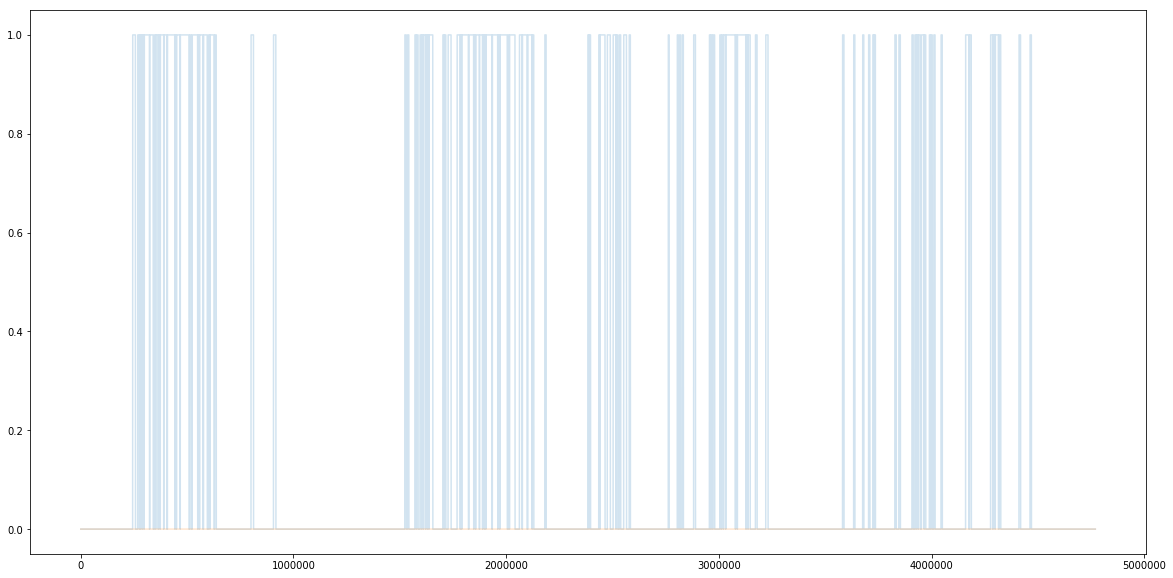

epoch 0 loss 2997011398.5349727 time 260.1036469936371


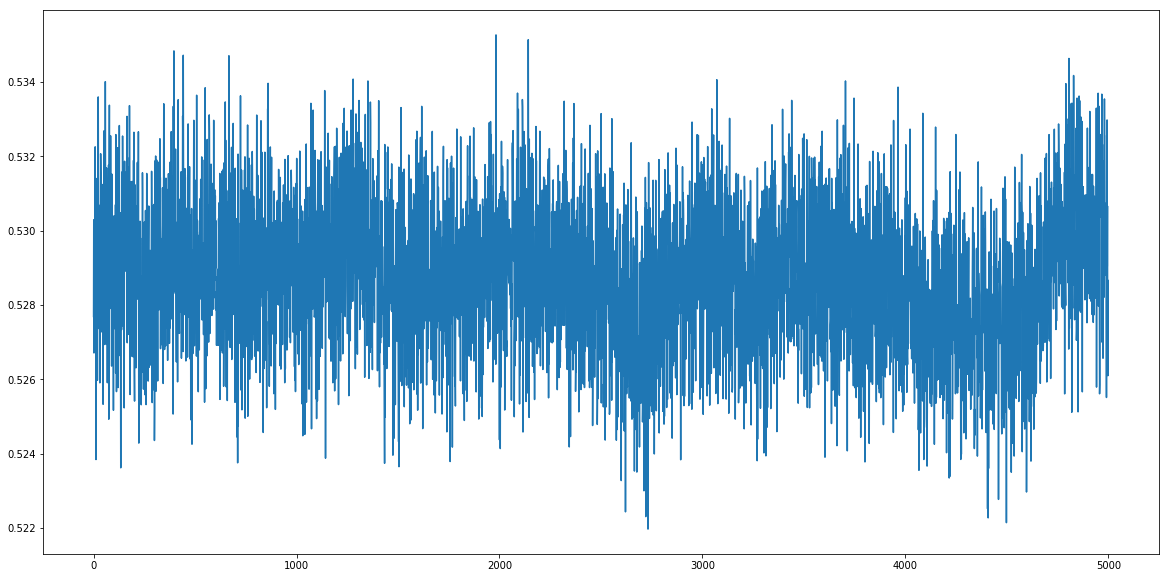

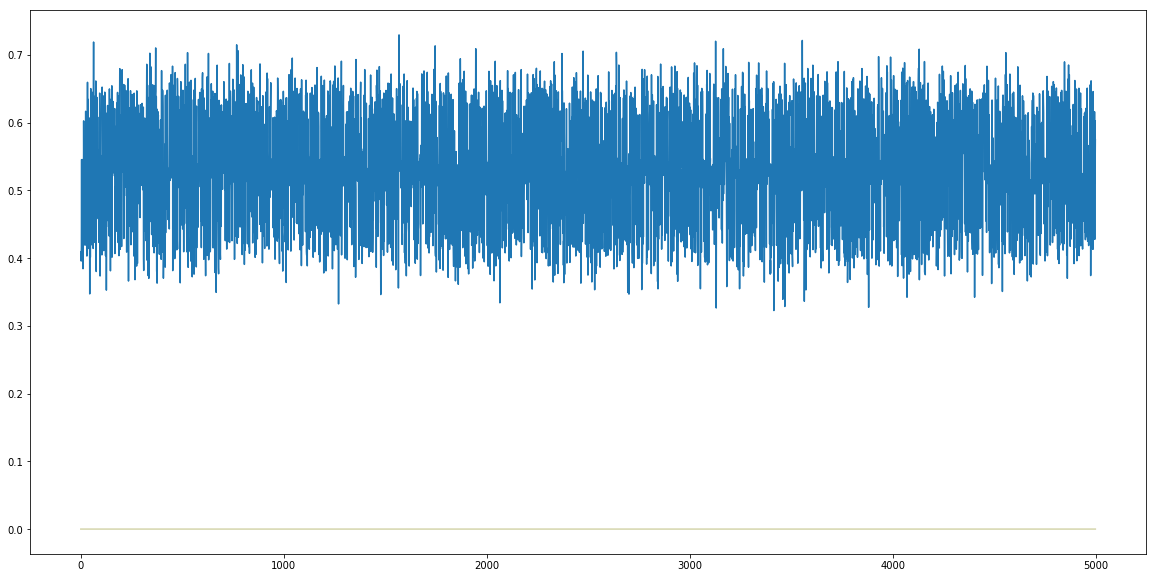

In [ ]:
window_size = 5*60*200
output_probs = 5000
learning_rate = 1e-4

#TODO add torch.save(the_model.state_dict(), PATH) this to save the best models weights

train_dataset = SleepDataset('/beegfs/ga4493/projects/groupb/data/training/RECORDS', '/beegfs/ga4493/projects/groupb/data/training/', 0, 1)

train_loaders = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=1,
                                           shuffle=True)

test_dataset = SleepDatasetTest('/beegfs/ga4493/projects/groupb/data/training/RECORDS', '/beegfs/ga4493/projects/groupb/data/training/', 4, 5)

test_loaders = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=1,
                                           shuffle=False)

model_v2 = Model_V2(window_size, output_probs)

if torch.cuda.is_available():
    print('using cuda')
    model_v2.cuda()
# TODO change this to BCEWithLogitsLoss
# criterion = nn.BCEWithLogitsLoss(size_average=False)
criterion = nn.MSELoss(size_average=False)

optimizer = torch.optim.RMSprop(model_v2.parameters(), lr=learning_rate, momentum=0.9)  
sig = nn.Sigmoid()

losses = []
v_losses = []
l = None
plotted = False
for epoch in range(1):
    loss_t = 0.0
    start_time = time.time()
    for i, ((all_data, centers), labels) in enumerate(train_loaders):
        if not plotted:
            fig = plt.figure(figsize=(20, 10))
            plt.plot(labels.numpy()[0] > 0, alpha=0.2)
            plt.plot(labels.numpy()[0] < 0, alpha=0.2)
            plt.show()
            plotted = True
        for i in range((all_data.size()[1]- 2*window_size)//output_probs - 1):
            sig_p = signal_window(window_size, output_probs, i)
            lab_p = label_window(window_size, output_probs, i)
            inp_subs = Variable(all_data[:,sig_p[0]:sig_p[1],].type(torch.FloatTensor).cuda())
            l = None
            if torch.cuda.is_available():
                l = Variable(labels[0, lab_p[0]:lab_p[1]].type(torch.FloatTensor).cuda())
            else:
                l = Variable(labels[0, lab_p[0]:lab_p[1]].type(torch.FloatTensor))
            output = model_v2(inp_subs)
            loss = criterion(output.view(-1), l)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_t += loss.data[0] / len(centers)

    losses.append(loss_t)
    print('epoch', epoch, 'loss', loss_t, 'time', time.time() - start_time)

v_all = []
for i in range((all_data.size()[1]- 2*window_size)//output_probs - 1):
    inp_subs = Variable(all_data[:,sig_p[0]:sig_p[1],].type(torch.FloatTensor).cuda())
    v_out = model_v2(inp_subs)
    v_out = sig(v_out)
    v_all = np.append(v_all, v_out.cpu().data[0].numpy())
    break
fig = plt.figure(figsize=(20, 10))
plt.plot(v_all)
plt.show()

v_all = []
i = 2
sig_p = signal_window(window_size, output_probs, i)
lab_p = label_window(window_size, output_probs, i)
inp_subs = Variable(all_data[:,sig_p[0]:sig_p[1],].type(torch.FloatTensor).cuda())
v_out = model_v2(inp_subs)
v_out = sig(v_out)
v_all = np.append(v_all, v_out.cpu().data[0].numpy())
fig = plt.figure(figsize=(20, 10))
plt.plot(v_all)
plt.plot(labels.numpy()[0][lab_p[0]:lab_p[1]] > 0, alpha=0.2)
plt.plot(labels.numpy()[0][lab_p[0]:lab_p[1]] < 0, alpha=0.2)
#     fig.savefig(os.path.join(image_dir, 'epoch-{:03d}_Train-{:.0E}_lr-{}_ws-{}_hanw.png'.format(epoch, learning_rate, window_size, hanning_window)))
#     plt.close(fig)
plt.show()

for i, ((all_data, centers), labels) in enumerate(test_loaders):
    v_all = []
    for i in range((all_data.size()[1]- 2*window_size)//output_probs - 1):
        inp_subs = Variable(all_data[:,sig_p[0]:sig_p[1],].type(torch.FloatTensor).cuda())
        v_out = model_v2(inp_subs)
        v_out = sig(v_out)
        v_all = np.append(v_all, v_out.cpu().data[0].numpy())
    fig = plt.figure(figsize=(20, 10))
    plt.plot(v_all)
    plt.plot(labels.numpy()[0][window_size//2 - output_probs//2:] > 0, alpha=0.2)
    plt.plot(labels.numpy()[0][window_size//2 - output_probs//2:] < 0, alpha=0.2)
#     fig.savefig(os.path.join(image_dir, 'epoch-{:03d}_Train-{:.0E}_lr-{}_ws-{}_hanw.png'.format(epoch, learning_rate, window_size, hanning_window)))
#     plt.close(fig)
    plt.show()

fig = plt.figure(figsize=(10, 10))
plt.plot(losses)
plt.show()
# fig.savefig(os.path.join(image_dir, 'Losses{:.0E}_lr-{}_ws-{}_hanw.png'.format(learning_rate, window_size, hanning_window)))
# plt.close(fig)

In [48]:
v_out

Variable containing:
(  0  ,  0  ,.,.) = 
  0.5000
  0.5000
  0.5000
   ⋮    
  0.5000
  0.5000
  0.5000
[torch.cuda.FloatTensor of size 1x1x12000x1 (GPU 0)]